# K Nearest Neighbours 

used when data is in clusters

## Data Processing

In [3]:
import sklearn
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd 
import numpy as np
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

/tmp/ipykernel_4221/3734432386.py:4: DeprecationWarning:


Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        



In [6]:
data = pd.read_csv("./datasets/car.csv")
display(data.head(5))

,buying,maint,door,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [7]:
le = preprocessing.LabelEncoder()
buying = le.fit_transform(list(data["buying"]))
maint = le.fit_transform(list(data["maint"]))
door = le.fit_transform(list(data["door"]))
persons = le.fit_transform(list(data["persons"]))
lug_boot = le.fit_transform(list(data["lug_boot"]))
safety = le.fit_transform(list(data["safety"]))
cls = le.fit_transform(list(data["class"]))

x = list(zip(buying, maint, door, persons, lug_boot, safety))
y = list(cls)

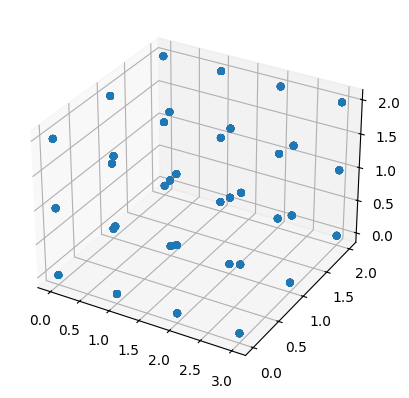

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter3D(buying, safety, persons)

In [9]:
import plotly.express as px 
fig = px.scatter_3d(data, x="buying", y="safety", z="class")
fig.show()

## Preparing the model

In [24]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y)
model = KNeighborsClassifier(n_neighbors=7) # n_neighbors is a hyperparameter that changes as we go

best = 0
def train():
    model.fit(x_train, y_train)
    acc = model.score(x_test, y_test)
    return acc

import pickle 

with open("./models/car.pickle", "wb") as f:
    pickle.dump(model, f)

for i in range(30):
    acc = train()
    if acc > best:
        best = acc
        pickle_in = open("./models/car.pickle", "rb")
        model = pickle.load(pickle_in)

print(best)


0.9305555555555556


In [34]:
names = ["unacc", "acc", "good", "vgood"]
predictions = model.predict(x_test)

for i in range(len(x_test)):
    print(f"Predicted: {names[predictions[i]]}, Actual: {names[y_test[i]]}, Data: {x_test[i]}")
    print(model.kneighbors([x_test[i]], 9, True)) # returns two arrays, first data 

Predicted: good, Actual: unacc, Data: (1, 0, 2, 2, 2, 2)
(array([[1.        , 1.        , 1.        , 1.        , 1.41421356,
        1.41421356, 1.41421356, 1.41421356, 1.41421356]]), array([[ 443, 1054, 1201,  372,  495,  825, 1261, 1088,  172]]))
Predicted: good, Actual: good, Data: (2, 2, 2, 0, 1, 2)
(array([[1., 1., 1., 1., 1., 1., 1., 1., 1.]]), array([[1005, 1131,  581,  475,  254,  139,  913, 1289,  104]]))
Predicted: good, Actual: good, Data: (2, 2, 0, 1, 0, 1)
(array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.41421356]]), array([[ 567,  326,  995, 1165,  332,  466,  575, 1257,  248]]))
Predicted: good, Actual: good, Data: (2, 0, 3, 1, 2, 1)
(array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.41421356, 1.41421356, 1.41421356]]), array([[1115,  872,  211, 1020,  985,  844,  374,  770,  638]]))
Predicted: good, Actual: good, Data: (2, 2, 1, 0, 0, 0)
(array([[1.        , 1.    

## Plotting the KNN graph

/home/ronald/Documents/python/ml/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ronald/Documents/python/ml/venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


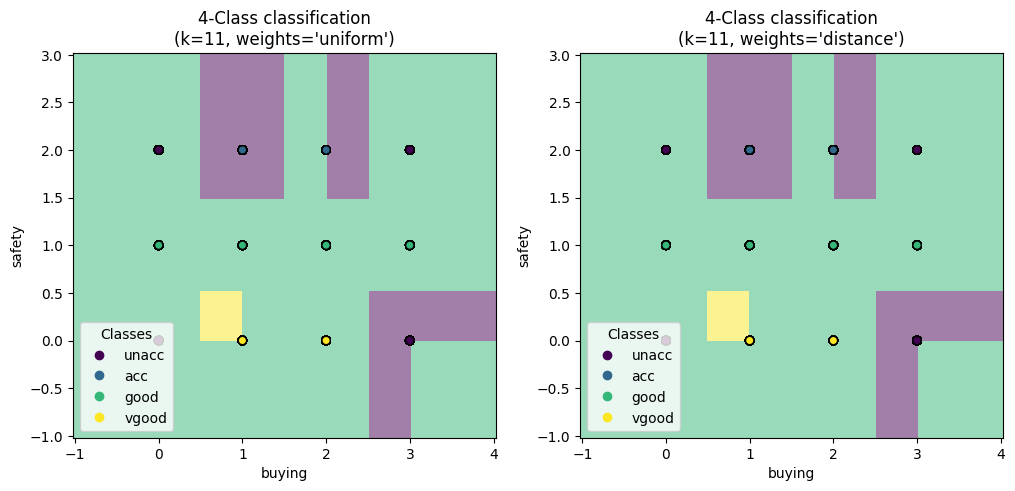

In [59]:
x = list(zip(buying,safety))
y = list(cls)
X = pd.DataFrame(x, columns=["buying", "safety"])
Y = pd.DataFrame(y, columns=["class"])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, stratify=Y, random_state=0)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="buying",
        ylabel="safety",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"4-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()